In [9]:
import pandas as pd
import json
from matplotlib import pyplot as plt
import re
import math
import numpy as np
from nltk.corpus import stopwords 
from collections import Counter
from wordcloud import WordCloud
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import Phrases
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
pd.options.mode.chained_assignment = None  # default='warn'

[nltk_data] Downloading package punkt to C:\Users\Cat
[nltk_data]     Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Cat
[nltk_data]     Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
video1 = "Jean, Maggie, Liz Buttner 8-13-19.csv"
df1 = pd.read_csv(video1)
video2 = "20-01-06 Liz Buttner, Jean, Maggie - HUB Groups CT.csv"
df2 = pd.read_csv(video2)

df = pd.concat([df1, df2], ignore_index=True)
df

,timestamp,name,text
0,[00:00:04.19],Jean,Uh BlueJeans has this wonderful ability to uh ...
1,[00:00:15.14],Liz,"I sure do, and I took some time as I was sitti..."
2,[00:01:08.00],Jean,OV:Well then you're ready to kind of dive into...
3,[00:01:29.10],Liz,Well you know what I think um[1.5-second-pause...
4,[00:02:58.00],Jean,That's right that's- that's- when we uh Brian ...
...,...,...,...
211,[01:10:06.18],Liz,We're here! Amen!
212,[01:10:07.08],Jean,We will let you know when the draft it ready
213,[01:10:12.06],Liz,"Please do, please do and thank you for includi..."
214,[01:10:20.24],Everyone,[Says thanks to one another]


In [11]:
#using regular expression to clean up gestures [say-hi],[pause] and OV's and the like
stop_words = set(stopwords.words('english')) #set of common words eg and the in at etc
stops = ["um","uh","ah", "n't"]
jean_keys = ["NGSX", "Science", "NGSS", "Connecticut", "Teachers",
             "state", "professional development", "scale", "adoption", "vision"]
df = df.fillna(0)
df = df.loc[df.text != 0]
cleaned_text= []

for index,row in df.iterrows():
    text=re.sub(r"OV:|\[.*\]|\(|\)|-{1,}|um", "", row["text"])
    tokens=word_tokenize(text)
    tokens = [w.lower() for w in tokens if w.lower() not in stop_words and w.lower() not in stops]
    tokens =[w for w in tokens if re.match(r"\w+", w)]
    for key in jean_keys:
        for i in range(len(tokens)):
            if tokens[i] == key.lower():
                tokens[i] = key
    cleaned_text.append(tokens)
    
df["tokens"] = cleaned_text
df = df.loc[(textlist != [] for textlist in df["tokens"])]

#create bigrams
tokens_list=df.groupby(by="text").tokens.first() #check for duplicate texts
bigram = Phrases(tokens_list, min_count=2)

bigrams=[bigram[d] for d in df["tokens"]]
df["bigrams"]=bigrams
df

,timestamp,name,text,tokens,bigrams
0,[00:00:04.19],Jean,Uh BlueJeans has this wonderful ability to uh ...,"[bluejeans, wonderful, ability, record, liz, s...","[bluejeans, wonderful, ability, record, liz, s..."
1,[00:00:15.14],Liz,"I sure do, and I took some time as I was sitti...","[sure, took, time, sitting, outside, pool, yes...","[sure, took, time, sitting, outside, pool, yes..."
2,[00:01:08.00],Jean,OV:Well then you're ready to kind of dive into...,"[well, ready, kind, dive, first, question, ado...","[well, ready, kind, dive, first_question, adop..."
3,[00:01:29.10],Liz,Well you know what I think um[1.5-second-pause...,"[well, know, think, leading, states, want, us,...","[well, know, think, leading, states, want, us,..."
4,[00:02:58.00],Jean,That's right that's- that's- when we uh Brian ...,"[right, brian, sarah, part, initial, rollout, ...","[right, brian, sarah, part, initial, rollout, ..."
...,...,...,...,...,...
209,[01:09:48.16],Liz,"That's right, we're dealing with human beings","[right, dealing, han, beings]","[right, dealing, han, beings]"
210,[01:09:52.09],Jean,"There some people, teachers that still wanna f...","[people, Teachers, still, wan, na, follow, scr...","[people, Teachers, still, wan_na, follow, scri..."
211,[01:10:06.18],Liz,We're here! Amen!,[amen],[amen]
212,[01:10:07.08],Jean,We will let you know when the draft it ready,"[let, know, draft, ready]","[let, know, draft, ready]"


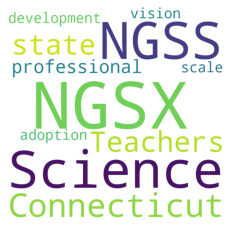

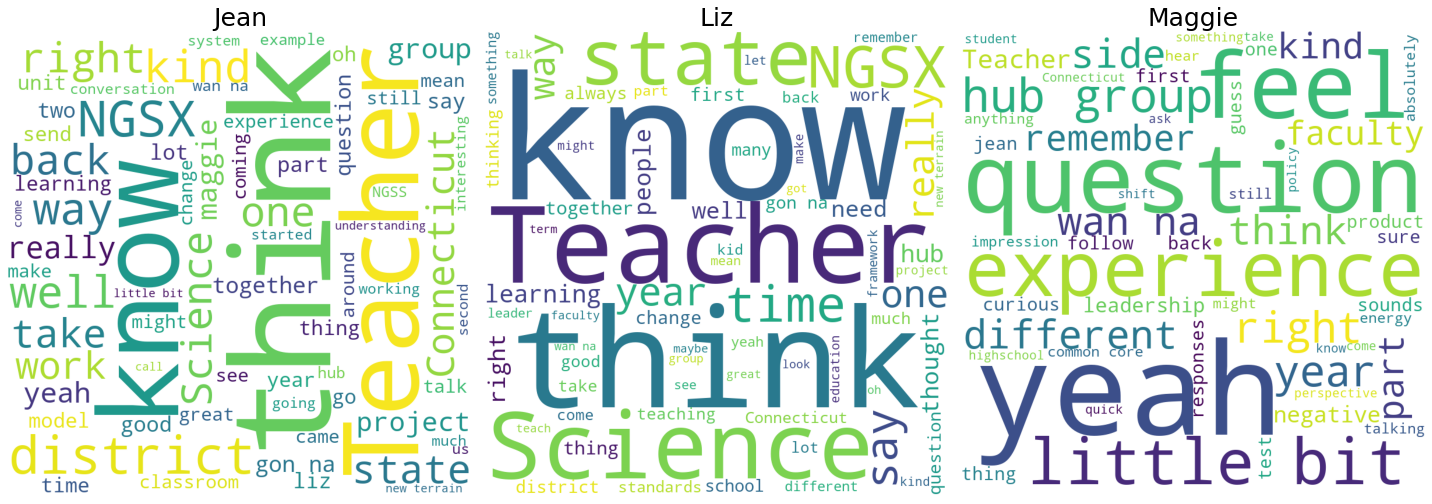

In [23]:
#picture for top words
plt.subplot(1,1,1)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',  
                min_font_size = 20).generate(" ".join(jean_keys))
plt.axis("off") 
plt.imshow(wordcloud)
plt.savefig("wordcloud_jean.png")

group = df.groupby(by = "name")
participants = list(group.groups.keys())
i = 1
plt.figure(figsize = (20,20), facecolor = None) 

for participant in participants:
    temp = group.groups[participant].tolist()
    part_df = df.loc[temp]
    words=[]
    for word in part_df["tokens"]:
        words.extend(word)
    
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',  
                min_font_size = 20).generate(" ".join(words)) 
    plt.subplot(1, len(participants), i)
    plt.imshow(wordcloud) 
    plt.title(participant, fontsize = 25)
    plt.axis("off") 
    i+= 1
plt.tight_layout()
plt.savefig("allparticipants_wordcloud.png")



In [13]:
#automatically detect groups of words - "Topic"

dictionary = Dictionary(df["bigrams"])
corpus=[dictionary.doc2bow(bigramlist) for bigramlist in df["bigrams"]]
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3) 

#create list of words in each topic
big_topic_list = lda_model.show_topics(formatted = False)
big_topic_terms = []

for tup in big_topic_list:
    terms = [liltup[0] for liltup in tup[1]]
    big_topic_terms.append(terms)
    
#find most probable topic associated with each text

topic_prob = []
topic_list = []
topic_terms = []
for d in df["bigrams"]:
    bow = dictionary.doc2bow(d)
    topic_distribution = lda_model.get_document_topics(bow)
    topic=sorted(topic_distribution, key=lambda x:x[1], reverse=True)[0]
    topic_list.append(topic[0])
    topic_prob.append(topic[1])
    topic_terms.append(big_topic_terms[topic[0]])
df["most_probable_topic"]=topic_list
df["topic_terms"] = topic_terms
df["topic_probability"]=topic_prob
df.to_csv("final_data.csv")
df

,timestamp,name,text,tokens,bigrams,most_probable_topic,topic_terms,topic_probability
0,[00:00:04.19],Jean,Uh BlueJeans has this wonderful ability to uh ...,"[bluejeans, wonderful, ability, record, liz, s...","[bluejeans, wonderful, ability, record, liz, s...",2,"[know, think, right, NGSX, one, Teachers, real...",0.921871
1,[00:00:15.14],Liz,"I sure do, and I took some time as I was sitti...","[sure, took, time, sitting, outside, pool, yes...","[sure, took, time, sitting, outside, pool, yes...",0,"[know, think, get, NGSX, well, time, Science, ...",0.984495
2,[00:01:08.00],Jean,OV:Well then you're ready to kind of dive into...,"[well, ready, kind, dive, first, question, ado...","[well, ready, kind, dive, first_question, adop...",0,"[know, think, get, NGSX, well, time, Science, ...",0.957161
3,[00:01:29.10],Liz,Well you know what I think um[1.5-second-pause...,"[well, know, think, leading, states, want, us,...","[well, know, think, leading, states, want, us,...",0,"[know, think, get, NGSX, well, time, Science, ...",0.977291
4,[00:02:58.00],Jean,That's right that's- that's- when we uh Brian ...,"[right, brian, sarah, part, initial, rollout, ...","[right, brian, sarah, part, initial, rollout, ...",0,"[know, think, get, NGSX, well, time, Science, ...",0.927906
...,...,...,...,...,...,...,...,...
209,[01:09:48.16],Liz,"That's right, we're dealing with human beings","[right, dealing, han, beings]","[right, dealing, han, beings]",1,"[know, think, Teachers, state, NGSX, Science, ...",0.856744
210,[01:09:52.09],Jean,"There some people, teachers that still wanna f...","[people, Teachers, still, wan, na, follow, scr...","[people, Teachers, still, wan_na, follow, scri...",2,"[know, think, right, NGSX, one, Teachers, real...",0.946806
211,[01:10:06.18],Liz,We're here! Amen!,[amen],[amen],0,"[know, think, get, NGSX, well, time, Science, ...",0.651784
212,[01:10:07.08],Jean,We will let you know when the draft it ready,"[let, know, draft, ready]","[let, know, draft, ready]",0,"[know, think, get, NGSX, well, time, Science, ...",0.853866
